In [2]:
# Logging
import logging
logger = logging.getLogger(__name__)
basic_formatter = logging.Formatter('[%(asctime)s] %(message)s')
handler = logging.StreamHandler()
handler.setFormatter(basic_formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [3]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

import itertools
import json
import os
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import json_tricks as jt
import networkx as nx
import numpy as np
import pandas as pd
import varcompfa as vcf
from collections import defaultdict

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Set print options for reporting
np.set_printoptions(suppress=True, precision=6)

In [5]:
def load_df(contexts):
    """Load contexts into a DataFrame with some preprocessing"""
    ret = pd.DataFrame(contexts)
    from numbers import Number
    
    def make_hashable(elem):
        if isinstance(elem, Number):
            return elem
        elif isinstance(elem, np.ndarray) and elem.ndim == 0:
            return elem.item()
        else:
            return tuple(elem)
    
    # Make it possible to hash (and therefore group) certain columns
    ret['obs'] = ret['obs'].apply(make_hashable)
    ret['obs_p'] = ret['obs_p'].apply(make_hashable)
    
    return ret

def parameter_search(base, vary):
    names, values = zip(*vary.items())
    for case in itertools.product(*values):
        yield {**base, **dict(zip(names, case))}
        
def summarize(arr, axis=0):
    ret = {
        'mean': np.mean(arr, axis=axis),
        'var' : np.var(arr, axis=axis),
        'min' : np.min(arr, axis=axis),
        'max' : np.max(arr, axis=axis)
    }
    return ret

In [6]:
env = gym.make('PaperComplexMDP-v0')
phi = vcf.features.BinaryVector(env.observation_space.n)

num_states = env.observation_space.n
states = np.arange(num_states)
fmat   = np.array([phi(s) for s in states])


# Specify behavior policy
policy_dct = {
    0: [(0, 1)],
    1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
    2: [(0, 1), (1, 8), (2, 1)],
    3: [(0, 2), (1, 3), (2, 5)],
    4: [(0, 5), (1, 5)]
}

# Setup behavior policy
control = vcf.policies.DiscreteFixed(policy_dct)

# Specify state dependent parameters
gm_dct = {
    0: 0.5,
    1: 0.4,
    2: 0.1,
    3: 1.0,
    4: 0.0
}

kp_dct = {
    0: 1.0,
    1: 0.9,
    2: 0.0,
    3: 0.5,
    4: 0.1,
}

[2017-02-14 23:42:24,869] Making new env: PaperComplexMDP-v0


In [10]:
from numpy.linalg import pinv

gvec = np.array([gm_dct[i] for i in states])
kvec = np.array([kp_dct[i] for i in states])

# Analytical soln
I = np.eye(num_states)
Γ = np.diag(gvec)
Λ = np.diag(kvec)

P = np.array([
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.2, 0.0, 0.4, 0.4, 0.0],
    [0.1, 0.0, 0.0, 0.0, 0.9],
    [0.0, 0.2, 0.0, 0.0, 0.8],
    [0.5, 0.0, 0.5, 0.0, 0.0]
])

R = np.array([
       [ 0.      , -0.5     ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.222222],
       [ 0.      ,  1.      ,  0.      ,  0.      ,  1.625   ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ]])

rvec = (P*R) @ np.ones(num_states)

v_pi = pinv(I - P @ Γ) @ rvec
# v_pi = np.array([-0.244592,  0.638482,  1.086663,  1.554117, -0.006533])
v_kp = pinv(I - P @ Γ @ Λ) @ rvec

Δ = np.zeros((num_states, num_states))
for i, j in np.ndindex(*Δ.shape):
    Δ[i,j] = R[i,j] + gvec[j]*v_pi[j] - v_pi[i]

# Expected TD error
dvec = (P*Δ) @ np.ones(num_states)
ds_vec = (P*Δ**2) @ np.ones(num_states)

In [11]:
v_pi

array([-0.244176,  0.63956 ,  1.087791,  1.551165, -0.006654])

In [12]:
v_kp

array([-0.405223,  0.263269,  1.079739,  1.518955, -0.101306])

Running experiments with λ=0.0, λ_bar=0.0
λ=0.0, κ={0: 1.0, 1: 0.9, 2: 0.0, 3: 0.5, 4: 0.1}, λ_bar=0.0
**********************************************************************


,mean_return,var_return,mean_kp_return,var_kp_return,avg_values,avg_direct,avg_second,final_values,final_direct,final_second
0,-0.245906,0.188425,-0.265563,0.136077,-0.277428,0.124513,0.123268,-0.244610,0.142976,0.141499
1,0.637259,1.179119,0.594317,1.047566,0.527457,0.968740,0.959053,0.656148,1.106268,1.095372
2,1.090715,0.523769,1.089708,0.524931,1.041417,0.533543,0.528207,1.070636,0.498211,0.493202
3,1.557039,0.246125,1.552534,0.238177,1.369195,0.345922,0.342463,1.559257,0.238970,0.236610
4,-0.006063,0.039418,-0.013154,0.031055,-0.016601,0.029551,0.029256,-0.008246,0.031490,0.031173


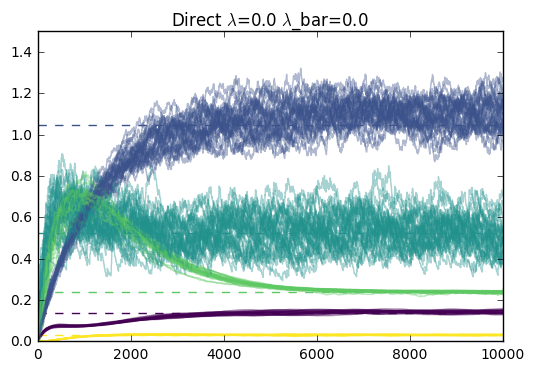

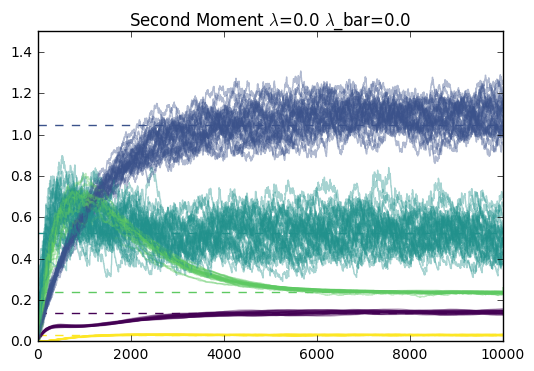

Running experiments with λ=0.0, λ_bar=1.0
λ=0.0, κ={0: 1.0, 1: 0.9, 2: 0.0, 3: 0.5, 4: 0.1}, λ_bar=1.0
**********************************************************************


,mean_return,var_return,mean_kp_return,var_kp_return,avg_values,avg_direct,avg_second,final_values,final_direct,final_second
0,-0.243268,0.186612,-0.262889,0.134779,-0.275577,0.130595,0.135568,-0.239025,0.140057,0.137537
1,0.642191,1.165581,0.600158,1.036575,0.533266,0.964283,0.983279,0.640263,1.080441,1.070659
2,1.087216,0.525116,1.086301,0.526049,1.036435,0.532132,0.527012,1.077684,0.543054,0.537165
3,1.554763,0.245832,1.551113,0.238038,1.367355,0.348956,0.346914,1.558830,0.238772,0.235896
4,-0.007127,0.039390,-0.014443,0.030935,-0.017371,0.031180,0.031822,-0.007654,0.030724,0.030216


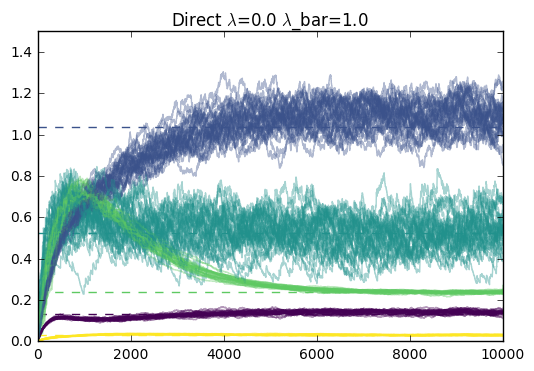

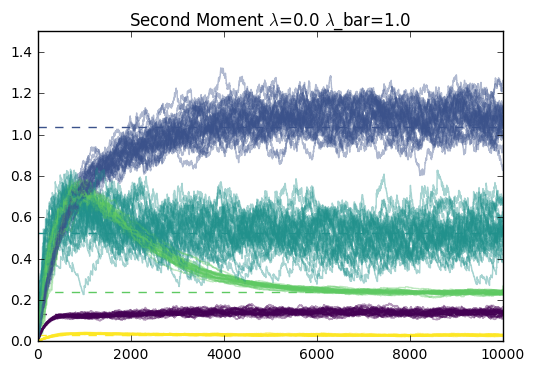

In [38]:
# Learning from scratch
pkgdir = os.path.dirname(os.path.dirname(vcf.__file__))
NUM_RUNS = 30
NUM_EPISODES = 1
MAX_STEPS = 10000
SAVE_RESULTS = False
OUTDIR = os.path.join(pkgdir, 'results', 'complex_sweep')
NAME_FMT = "lambda={lmbda!s}_lambda_bar={lmbda_bar!s}"


# Parameters to search over
base = {
    'alpha': 0.01,
    'gamma': gm_dct,
    'kappa': kp_dct,
}

vary = {
    'lmbda': [0.0],
    'lmbda_bar': [0.0, 1.0]
}





for params in parameter_search(base, vary):
    print("Running experiments with λ={lmbda}, λ_bar={lmbda_bar}".format(**params))
    # Define state-dependent parameters
    gamma = vcf.parameters.Map(params['gamma'], key='obs')
    gamma_p = vcf.parameters.Map(params['gamma'], key='obs_p')
    kappa = vcf.parameters.Map(params['kappa'], key='obs')
    kappa_p = vcf.parameters.Map(params['kappa'], key='obs_p')

    # Basename for output files
    basename = NAME_FMT.format(**params)
    
    value_params = {
        'alpha': params['alpha'],
        'gm': gamma,
        'gm_p': gamma_p,
        'lm': params['lmbda'],
        'lm_p': params['lmbda'],
    }
    
    direct_params = {
        'alpha': params['alpha'],
        'gm'   : lambda x: (gamma(x)*kappa(x))**2,
        'gm_p' : lambda x: (gamma_p(x)*kappa_p(x))**2,
        'lm'   : params['lmbda_bar'],
        'lm_p' : params['lmbda_bar'],
    }

    second_params = {
        'alpha': params['alpha'],
        'gm'   : lambda x: (gamma(x)*kappa(x))**2,
        'gm_p' : lambda x: (gamma_p(x)*kappa_p(x))**2,
        'lm'   : params['lmbda_bar'],
        'lm_p' : params['lmbda_bar'],
    }
    
    # Direct variance algorithm
    def direct_reward(ctx):
        return value_agent.get_td_error(ctx)**2
    
    # Second moment algorithm
    def second_moment_reward(ctx):
        # Get information from the value agent
        v_gm = value_params['gm'](ctx)
        v_gm_p = value_params['gm_p'](ctx)    
        v_nxt = value_agent.get_value(ctx['obs_p'])

        # For estimating different lambda-return than the value function 
        v_lm_p = kappa_p(ctx)

        # Compute next "reward"
        g_bar = ctx['r'] + v_gm_p * (1-v_lm_p) * v_nxt
        r_bar = g_bar**2 + 2*v_gm_p * v_lm_p * g_bar * v_nxt
        return r_bar
    
    
    # Will store run data
    run_df = []
    for run in range(NUM_RUNS):
        print("Run %d of %d..."%(run+1, NUM_RUNS), end="\r")
        value_agent = vcf.Agent(vcf.algos.TD(len(phi)), phi, value_params)
        
        direct_agent = vcf.Agent(vcf.algos.TD(len(phi)), phi, direct_params,
                                reward_func=direct_reward)
        
        second_agent = vcf.Agent(vcf.algos.TD(len(phi)), phi, second_params,
                                reward_func=second_moment_reward)
        
        
        # Set experiment
        learners = [direct_agent, second_agent, value_agent]
        experiment = vcf.LiveExperiment(env, control, learners=learners)
        
        # Set up callbacks to record runs
        exclusions = ['x', 'xp']
        value_hist = vcf.callbacks.AgentHistory(value_agent, exclude=exclusions, 
                                                compute={'v_p' : lambda x: value_agent.get_value(x['obs_p']),
                                                         'kp'  : lambda x: kappa(x),
                                                         'kp_p' : lambda x: kappa_p(x),
                                                         'w_value': lambda x: value_agent.algo.weights,
                                                         'w_direct': lambda x: direct_agent.algo.weights,
                                                         'w_second': lambda x: second_agent.algo.weights,
                                                         'r_bar' : lambda x: second_moment_reward(x)})

        # Set the callbacks and run the experiment
        callbacks = [value_hist]
        experiment.run(NUM_EPISODES, max_steps=MAX_STEPS, callbacks=callbacks, warn_step_limit=False)
        
        # Convert the run's history to a DataFrame
        df = load_df(value_hist.contexts)
        
        # Process dataframe
        df['delta'] = df['update_result'].apply(lambda x: x['delta'])
        df['delta_sq'] = df['delta']**2
        
        # Compute relevant quantities
        df['G'] = vcf.analysis.calculate_return(df['r'], df['gm_p'])
        df['td_values']  = df['w_value'].apply(lambda x: np.dot(fmat, x))
        df['direct_variances'] = df['w_direct'].apply(lambda x: np.dot(fmat, x))
        df['second_values'] = df['w_second'].apply(lambda x: np.dot(fmat, x))
        df['second_variances'] = df['second_values'] - df['td_values']**2
        
        # Compute lambda and kappa returns (using next value, not asymptotic value function)
        df['G_lm'] = vcf.analysis.calculate_lambda_return(df.r, df.gm_p, df.lm_p, df.v_p)
        df['G_kp'] = vcf.analysis.calculate_lambda_return(df.r, df.gm_p, df.kp_p, df.v_p)
        
        # Remove some columns to reduce memory use
        df.drop(['a', 't', 'total_steps', 'update_result', 'done', 'alpha'], axis=1, inplace=True)
        
        # Preserve the run dataframe
        run_df.append(df)
        
    # Collect dataframes from all runs
    run_df = pd.concat(run_df, keys=range(NUM_RUNS), names=['run', 't'])
        
    # Perform analysis for Craig
    res = {
        'td': defaultdict(list),
        'second_moment': defaultdict(list),
        'direct': defaultdict(list),
    }
    
    # Group by timestep
    grouped = run_df.groupby(level='t')

    # Summarize over the runs
    for i, group in grouped:
        for key, val in summarize(np.vstack(group['td_values'])).items():
            res['td'][key].append(val)
            
        for key, val in summarize(np.vstack(group['direct_variances'])).items():
            res['direct'][key].append(val)
            
        for key, val in summarize(np.vstack(group['second_variances'])).items():
            res['second_moment'][key].append(val)
     

    # ############################################################
    # Some results for quick comparison
    # ############################################################
    columns = ['mean_return', 'var_return',
               'mean_kp_return', 'var_kp_return',
               'avg_values', 'avg_direct', 'avg_second',
               'final_values', 'final_direct', 'final_second']
    summary_df = pd.DataFrame(index=np.arange(num_states), columns=columns)

    # Average values over entire run + values from near end of runs
    summary_df['avg_values'] = np.mean(res['td']['mean'], axis=0)
    summary_df['avg_direct'] = np.mean(res['direct']['mean'], axis=0)
    summary_df['avg_second'] = np.mean(res['second_moment']['mean'], axis=0)
    summary_df['final_values'] = np.mean(res['td']['mean'][-10:], axis=0)
    summary_df['final_direct'] = np.mean(res['direct']['mean'][-10:], axis=0)
    summary_df['final_second'] = np.mean(res['second_moment']['mean'][-10:], axis=0)

    # Compare with the empirical results
    grouped_obs = run_df.groupby('obs')
    summary_df['mean_return'] = grouped_obs['G'].mean()
    summary_df['var_return'] = grouped_obs['G'].var()
    summary_df['mean_kp_return'] = grouped_obs['G_kp'].mean()
    summary_df['var_kp_return'] = grouped_obs['G_kp'].var()

    # Fill NaN values (typically terminal states from empirical results)
    summary_df.fillna(0, inplace=True)

    # Print the results to terminal
    print("λ={lmbda}, κ={kappa}, λ_bar={lmbda_bar}".format(**params))
    print("*"*70)
#     print(summary_df) 
    display(summary_df)
    
    # Convert to Craig's format
    for name, dct in res.items():
        for key, val in dct.items():
            dct[key] = np.array(val).T.tolist()
    
    
    # Record some metadata
    res['metadata'] = {
        'num_runs': NUM_RUNS,
        'num_episodes': NUM_EPISODES,
        'environment': env.spec.id,
        'params': params,
        'agent_metadata': value_hist.metadata,
    }
    


    # Plotting
    g_run = run_df.groupby(level='run')

    fig, ax = plt.subplots()
    colors = mpl.cm.viridis(np.linspace(0, 1, len(states)))
    colors = colors[:, :3] # Remove alpha values
    
    for name in g_run.groups:
        group = g_run.get_group(name)
        xdata = group.index.get_level_values('t')
        ydata = np.vstack(group['direct_variances']).T
        for ix, s in enumerate(states):
            ax.plot(xdata, ydata[ix], color=(*colors[ix], 0.4))

    ax.set_ylim([0, 1.5])
    ax.set_title("Direct $\lambda$={lmbda} $\lambda$_bar={lmbda_bar}".format(**params))

    # True values
    x_lim = ax.get_xlim()
    for s, ix in enumerate(states):
        ax.hlines(summary_df['var_kp_return'][s], *x_lim, colors=(*colors[ix], 1), linestyles='--')
    
    plt.show()
    ##########
    
    fig, ax = plt.subplots()
    for name in g_run.groups:
        group = g_run.get_group(name)
        xdata = group.index.get_level_values('t')
        ydata = np.vstack(group['second_variances']).T
        for ix, s in enumerate(states):
            
            ax.plot(xdata, ydata[ix], color=(*colors[ix], 0.4))

    # True values
    x_lim = ax.get_xlim()
    for s, ix in enumerate(states):
        ax.hlines(summary_df['var_kp_return'][s], *x_lim, colors=(*colors[ix], 1), linestyles='--')
    
    ax.set_ylim([0, 1.5])
    ax.set_title("Second Moment $\lambda$={lmbda} $\lambda$_bar={lmbda_bar}".format(**params))


    plt.show()
    ##########

In [36]:
(*colors[ix], 1)

(0.99324800000000002, 0.90615699999999999, 0.14393600000000001, 1)

In [186]:
print(summary_df)

   mean_return  var_return  mean_kp_return  var_kp_return  avg_values  \
0    -0.242588    0.188805       -0.261976       0.136484   -0.275604   
1     0.642346    1.180445        0.601232       1.050355    0.533061   
2     1.084207    0.526729        1.083199       0.527750    1.032941   
3     1.554230    0.247277        1.550993       0.239003    1.367963   
4    -0.008025    0.039737       -0.015439       0.031160   -0.018230   

   avg_direct  avg_second  final_values  final_direct  final_second  
0    0.131859    0.137179     -0.238881      0.144500      0.142779  
1    0.975021    0.993552      0.647596      1.106135      1.097439  
2    0.535727    0.530660      1.080842      0.515493      0.510380  
3    0.353348    0.350450      1.552414      0.237756      0.234245  
4    0.031427    0.032072     -0.007556      0.031497      0.031079  


# Given Fixed Value Function (v_pi)

Note how much noisier the second moment algorithm is...

Running experiments with λ=0.0, λ_bar=0.0
λ=0.0, κ={0: 1.0, 1: 0.9, 2: 0.0, 3: 0.5, 4: 0.1}, λ_bar=0.0
**********************************************************************


,mean_return,var_return,mean_kp_return,var_kp_return,avg_values,avg_direct,avg_second,final_values,final_direct,final_second
0,-0.245012,0.189253,-0.244483,0.142829,-0.244176,0.128528,0.119106,-0.244176,0.143896,0.141935
1,0.636171,1.181350,0.637223,1.100999,0.639560,1.047728,0.999065,0.639560,1.107742,1.115578
2,1.086690,0.526340,1.086687,0.525142,1.087791,0.502521,0.448121,1.087791,0.509022,0.464579
3,1.548238,0.247841,1.548310,0.238821,1.551165,0.209539,-0.067840,1.551165,0.238349,0.237911
4,-0.006732,0.039710,-0.006785,0.031210,-0.006654,0.028317,0.027155,-0.006654,0.030929,0.030568


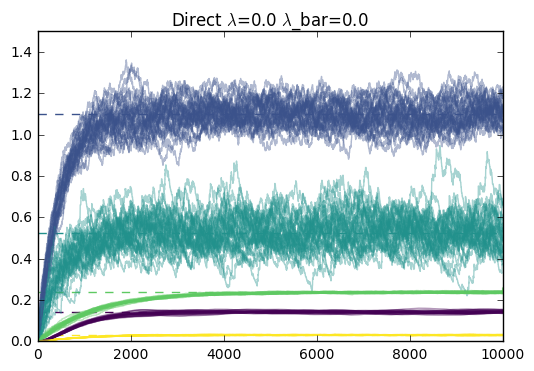

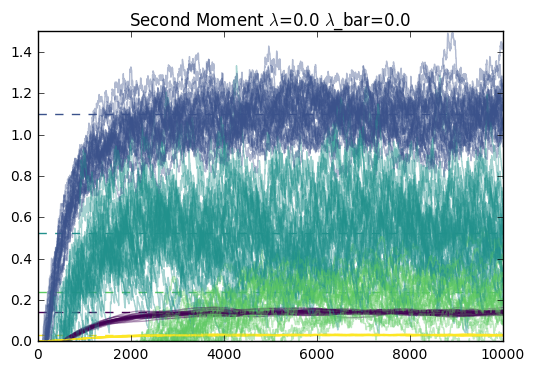

Running experiments with λ=0.0, λ_bar=1.0
λ=0.0, κ={0: 1.0, 1: 0.9, 2: 0.0, 3: 0.5, 4: 0.1}, λ_bar=1.0
**********************************************************************


,mean_return,var_return,mean_kp_return,var_kp_return,avg_values,avg_direct,avg_second,final_values,final_direct,final_second
0,-0.243443,0.186541,-0.243085,0.141028,-0.244176,0.134509,0.132326,-0.244176,0.139333,0.139109
1,0.639341,1.165832,0.640451,1.088278,0.639560,1.042855,1.027327,0.639560,1.067986,1.055329
2,1.083892,0.515776,1.083888,0.514627,1.087791,0.490952,0.425753,1.087791,0.542499,0.587400
3,1.547011,0.247960,1.547215,0.238706,1.551165,0.211028,-0.067479,1.551165,0.236543,0.235029
4,-0.006547,0.039096,-0.006233,0.030868,-0.006654,0.029914,0.029997,-0.006654,0.030671,0.030657


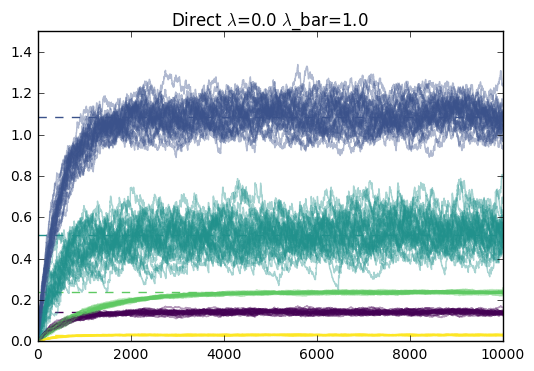

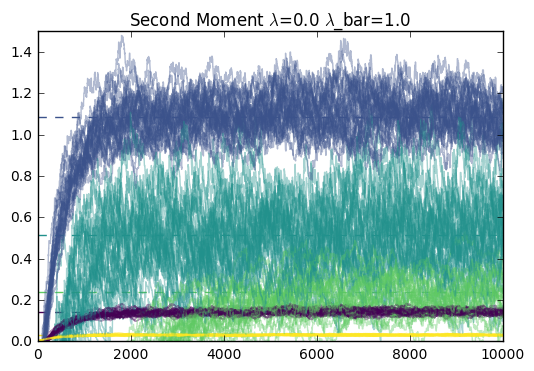

In [39]:
NUM_RUNS = 30
NUM_EPISODES = 1
MAX_STEPS = 10000
NAME_FMT = "lambda={lmbda!s}_lambda_bar={lmbda_bar!s}"


base = {
    'alpha': 0.01,
    'gamma': gm_dct,
    'kappa': kp_dct,
}


vary = {
    'lmbda': [0.0],
    'lmbda_bar': [0.0, 1.0]
}





for params in parameter_search(base, vary):
    print("Running experiments with λ={lmbda}, λ_bar={lmbda_bar}".format(**params))
    # Define state-dependent parameters
    gamma = vcf.parameters.Map(params['gamma'], key='obs')
    gamma_p = vcf.parameters.Map(params['gamma'], key='obs_p')
    kappa = vcf.parameters.Map(params['kappa'], key='obs')
    kappa_p = vcf.parameters.Map(params['kappa'], key='obs_p')

    # Basename for output files
    basename = NAME_FMT.format(**params)
    
    value_params = {
        'alpha': 0,
        'gm': gamma,
        'gm_p': gamma_p,
        'lm': params['lmbda'],
        'lm_p': params['lmbda'],
    }
    
    direct_params = {
        'alpha': params['alpha'],
        'gm'   : lambda x: (gamma(x)*kappa(x))**2,
        'gm_p' : lambda x: (gamma_p(x)*kappa_p(x))**2,
        'lm'   : params['lmbda_bar'],
        'lm_p' : params['lmbda_bar'],
    }

    second_params = {
        'alpha': params['alpha'],
        'gm'   : lambda x: (gamma(x)*kappa(x))**2,
        'gm_p' : lambda x: (gamma_p(x)*kappa_p(x))**2,
        'lm'   : params['lmbda_bar'],
        'lm_p' : params['lmbda_bar'],
    }
    
    # Direct variance algorithm
    def direct_reward(ctx):
        return value_agent.get_td_error(ctx)**2
    
    # Second moment algorithm
    def second_moment_reward(ctx):
        # Get information from the value agent
        v_gm = value_params['gm'](ctx)
        v_gm_p = value_params['gm_p'](ctx)    
        v_nxt = value_agent.get_value(ctx['obs_p'])

        # For estimating different lambda-return than the value function 
        v_lm_p = kappa_p(ctx)

        # Compute next "reward"
        g_bar = ctx['r'] + v_gm_p * (1-v_lm_p) * v_nxt
        r_bar = g_bar**2 + 2*v_gm_p * v_lm_p * g_bar * v_nxt
        return r_bar
    
    
    # Will store run data
    run_df = []
    for run in range(NUM_RUNS):
        print("Run %d of %d..."%(run+1, NUM_RUNS), end="\r")
        value_agent = vcf.Agent(vcf.algos.TD(len(phi)), phi, value_params)
        value_agent.algo.w = v_pi.copy()
        
        direct_agent = vcf.Agent(vcf.algos.TD(len(phi)), phi, direct_params,
                                reward_func=direct_reward)
        
        second_agent = vcf.Agent(vcf.algos.TD(len(phi)), phi, second_params,
                                reward_func=second_moment_reward)
#         second_agent.algo.w = v_pi.copy()**2
        
        
        # Set experiment
        learners = [direct_agent, second_agent, value_agent]
        experiment = vcf.LiveExperiment(env, control, learners=learners)
        
        # Set up callbacks to record runs
        exclusions = ['x', 'xp']
        value_hist = vcf.callbacks.AgentHistory(value_agent, exclude=exclusions, 
                                                compute={'v_p' : lambda x: value_agent.get_value(x['obs_p']),
                                                         'kp'  : lambda x: kappa(x),
                                                         'kp_p' : lambda x: kappa_p(x),
                                                         'w_value': lambda x: value_agent.algo.weights,
                                                         'w_direct': lambda x: direct_agent.algo.weights,
                                                         'w_second': lambda x: second_agent.algo.weights,
                                                         'r_bar' : lambda x: second_moment_reward(x)})

        # Set the callbacks and run the experiment
        callbacks = [value_hist]
        experiment.run(NUM_EPISODES, max_steps=MAX_STEPS, callbacks=callbacks, warn_step_limit=False)
        
        # Convert the run's history to a DataFrame
        df = load_df(value_hist.contexts)
        
        # Process dataframe
        df['delta'] = df['update_result'].apply(lambda x: x['delta'])
        df['delta_sq'] = df['delta']**2
        
        # Compute relevant quantities
        df['G'] = vcf.analysis.calculate_return(df['r'], df['gm_p'])
        df['td_values']  = df['w_value'].apply(lambda x: np.dot(fmat, x))
        df['direct_variances'] = df['w_direct'].apply(lambda x: np.dot(fmat, x))
        df['second_values'] = df['w_second'].apply(lambda x: np.dot(fmat, x))
        df['second_variances'] = df['second_values'] - df['td_values']**2
        
        # Compute lambda and kappa returns (using next value, not asymptotic value function)
        df['G_lm'] = vcf.analysis.calculate_lambda_return(df.r, df.gm_p, df.lm_p, df.v_p)
        df['G_kp'] = vcf.analysis.calculate_lambda_return(df.r, df.gm_p, df.kp_p, df.v_p)
        
        # Remove some columns to reduce memory use
        df.drop(['a', 't', 'total_steps', 'update_result', 'done', 'alpha'], axis=1, inplace=True)
        
        # Preserve the run dataframe
        run_df.append(df)
        
    # Collect dataframes from all runs
    run_df = pd.concat(run_df, keys=range(NUM_RUNS), names=['run', 't'])
        
    # Perform analysis for Craig
    res = {
        'td': defaultdict(list),
        'second_moment': defaultdict(list),
        'direct': defaultdict(list),
    }
    
    # Group by timestep
    grouped = run_df.groupby(level='t')

    # Summarize over the runs
    for i, group in grouped:
        for key, val in summarize(np.vstack(group['td_values'])).items():
            res['td'][key].append(val)
            
        for key, val in summarize(np.vstack(group['direct_variances'])).items():
            res['direct'][key].append(val)
            
        for key, val in summarize(np.vstack(group['second_variances'])).items():
            res['second_moment'][key].append(val)
     

    # ############################################################
    # Some results for quick comparison
    # ############################################################
    columns = ['mean_return', 'var_return',
               'mean_kp_return', 'var_kp_return',
               'avg_values', 'avg_direct', 'avg_second',
               'final_values', 'final_direct', 'final_second']
    summary_df = pd.DataFrame(index=np.arange(num_states), columns=columns)

    # Average values over entire run + values from near end of runs
    summary_df['avg_values'] = np.mean(res['td']['mean'], axis=0)
    summary_df['avg_direct'] = np.mean(res['direct']['mean'], axis=0)
    summary_df['avg_second'] = np.mean(res['second_moment']['mean'], axis=0)
    summary_df['final_values'] = np.mean(res['td']['mean'][-10:], axis=0)
    summary_df['final_direct'] = np.mean(res['direct']['mean'][-10:], axis=0)
    summary_df['final_second'] = np.mean(res['second_moment']['mean'][-10:], axis=0)

    # Compare with the empirical results
    grouped_obs = run_df.groupby('obs')
    summary_df['mean_return'] = grouped_obs['G'].mean()
    summary_df['var_return'] = grouped_obs['G'].var()
    summary_df['mean_kp_return'] = grouped_obs['G_kp'].mean()
    summary_df['var_kp_return'] = grouped_obs['G_kp'].var()

    # Fill NaN values (typically terminal states from empirical results)
    summary_df.fillna(0, inplace=True)

    # Print the results to terminal
    print("λ={lmbda}, κ={kappa}, λ_bar={lmbda_bar}".format(**params))
    print("*"*70)
#     print(summary_df) 
    display(summary_df)

    
    # Plotting
    g_run = run_df.groupby(level='run')

    fig, ax = plt.subplots()
    colors = mpl.cm.viridis(np.linspace(0, 1, len(states)))
    colors = colors[:, :3] # Remove alpha values
    
    for name in g_run.groups:
        group = g_run.get_group(name)
        xdata = group.index.get_level_values('t')
        ydata = np.vstack(group['direct_variances']).T
        for ix, s in enumerate(states):
            ax.plot(xdata, ydata[ix], color=(*colors[ix], 0.4))

    ax.set_ylim([0, 1.5])
    ax.set_title("Direct $\lambda$={lmbda} $\lambda$_bar={lmbda_bar}".format(**params))

    # True values
    x_lim = ax.get_xlim()
    for s, ix in enumerate(states):
        ax.hlines(summary_df['var_kp_return'][s], *x_lim, colors=(*colors[ix], 1), linestyles='--')
    
    plt.show()
    ##########
    
    fig, ax = plt.subplots()
    for name in g_run.groups:
        group = g_run.get_group(name)
        xdata = group.index.get_level_values('t')
        ydata = np.vstack(group['second_variances']).T
        for ix, s in enumerate(states):
            
            ax.plot(xdata, ydata[ix], color=(*colors[ix], 0.4))

    # True values
    x_lim = ax.get_xlim()
    for s, ix in enumerate(states):
        ax.hlines(summary_df['var_kp_return'][s], *x_lim, colors=(*colors[ix], 1), linestyles='--')
    
    ax.set_ylim([0, 1.5])
    ax.set_title("Second Moment $\lambda$={lmbda} $\lambda$_bar={lmbda_bar}".format(**params))


    plt.show()
    ##########

In [61]:
g_obs['G_kp'].var()

obs
0    0.135216
1    1.037855
2    0.516610
3    0.236594
4    0.031161
Name: G_kp, dtype: float64

In [57]:
g_obs['r_bar'].mean()

obs
0    0.248874
1    0.511694
2    1.603376
3    2.533042
4    0.000105
Name: r_bar, dtype: float64

In [58]:
g_obs['delta_sq'].mean()

obs
0    0.209197
1    0.512468
2    1.359237
3    2.337427
4    0.000381
Name: delta_sq, dtype: float64

In [93]:
# g_obs = run_df.groupby('obs')
# for ix, s in enumerate(states):
#     group = g_obs.get_group(s)
#     data  = 


SyntaxError: invalid syntax (<ipython-input-93-66de9e2822ee>, line 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f038de99ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f038dbc6be0>]], dtype=object)

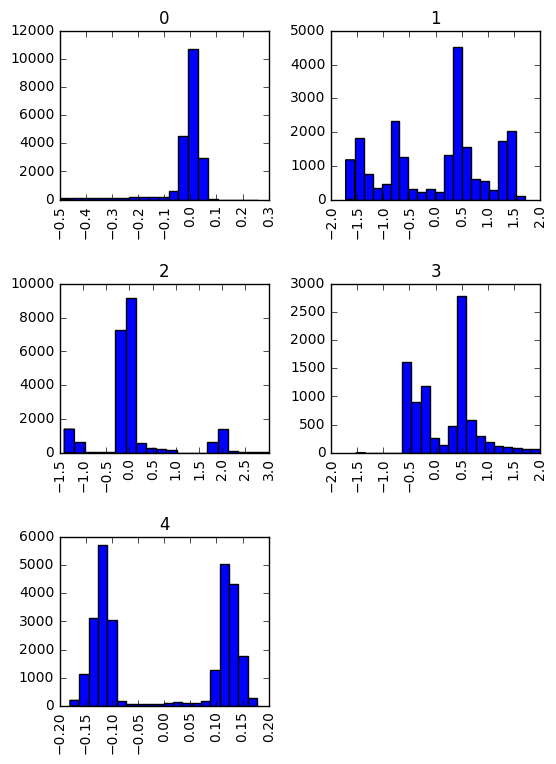

In [97]:
run_df.hist('delta', by='obs', bins=20, figsize=(6, 9))

obs
0    [[Axes(0.125,0.125;0.775x0.775)]]
1    [[Axes(0.125,0.125;0.775x0.775)]]
2    [[Axes(0.125,0.125;0.775x0.775)]]
3    [[Axes(0.125,0.125;0.775x0.775)]]
4    [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

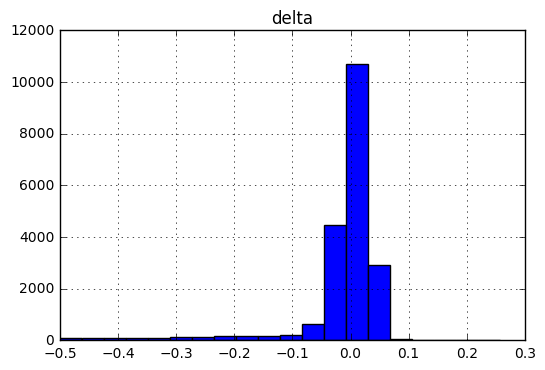

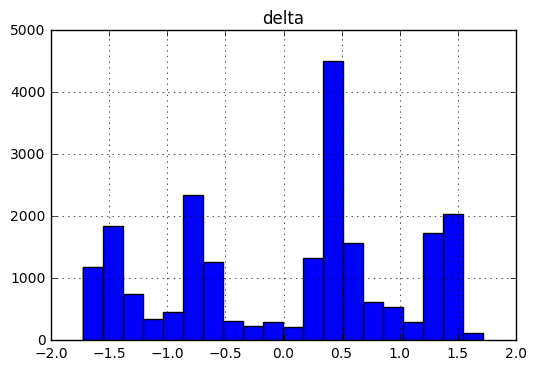

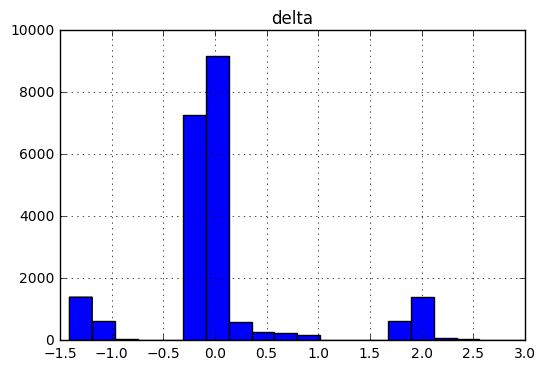

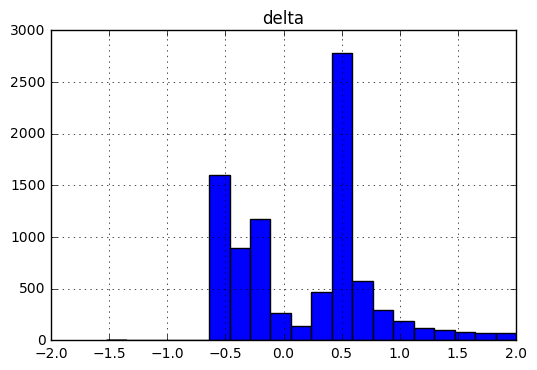

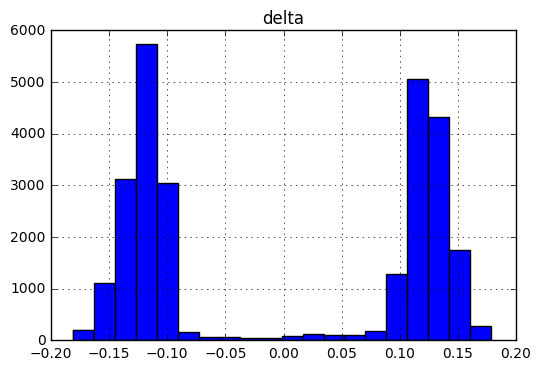

In [95]:
g_obs.hist(['delta'], bins=20)

In [ ]:
g_obs = run_df.groupby('obs')
g_obs.hist(['r_bar', 'delta_sq'], bins=np.linspace(0, 10, 50))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03918e2d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0391671a20>]], dtype=object)

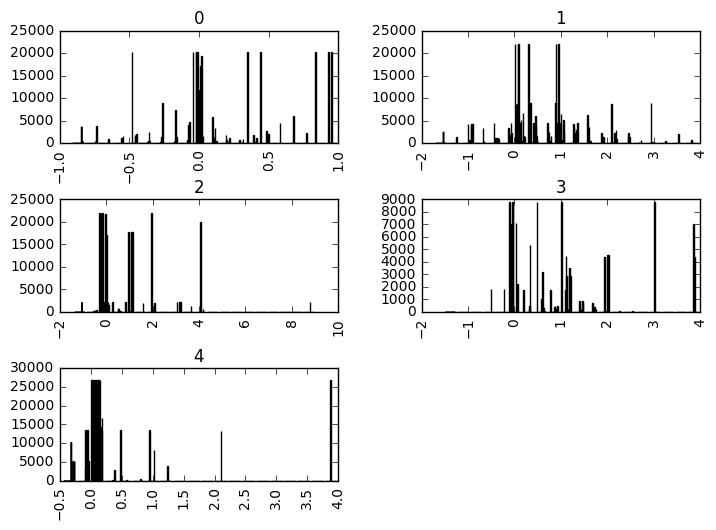

In [67]:
run_df.hist(['G_kp'], by='obs', figsize=(8, 6), bins=20)